In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import LSODA, solve_ivp
from scipy.special import jv, jve, iv, i1
from numpy.linalg import solve, inv
import numba
import sys


sys.path.append('../Numerical_methods')
from matrix_calculator import A_matrix
from scheme_calculator import forward_backward
from bachelor_funcs import get_first_dev

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

### Defining and testing analytical solution, eqs. 3.21

In [14]:
def analytic_green(x, τ):
    return (np.pi * τ)**(-1) * x**(-1/4) * np.exp(- (1 + x**2) / τ) * iv(1/4, 2*x / τ)
    
# https://docs.scipy.org/doc/scipy/reference/special.html
# Different kinds of bessel functions were tried - "Modified Bessel function of order 1." is the working one with the order sat to 1/4
# (Not including pi in the first part of the soultion gives the same scale on the y-axis as Armitage)

In [15]:
N = 2001
x_i = 0.01
x_f = 2.1
x = np.linspace(x_i, x_f, N)
Δx = x[1] - x[0]
Δt = 0.004

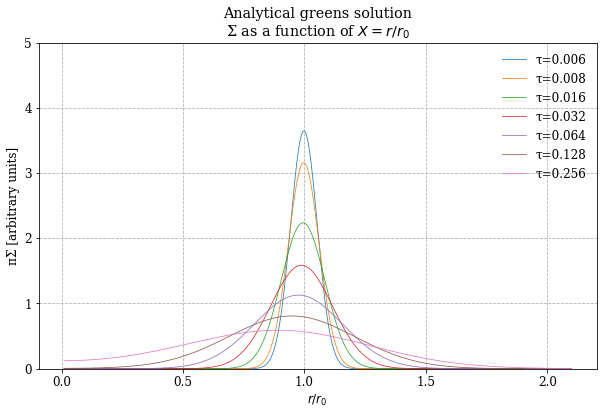

In [16]:
fig, axs = plt.subplots(figsize=(10,6)) 
plt.grid(ls='--')
times = [0.006, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256]
for τ in times:
    axs.plot(x, np.pi * analytic_green(x, τ), label=f'τ={τ}', lw=0.75)

axs.set(title='Analytical greens solution\nΣ as a function of $X=r/r_0$', ylabel='πΣ [arbitrary units]', xlabel='$r/r_0$', ylim = (0,5))
plt.legend(frameon=False)

### Change analytical solution to f

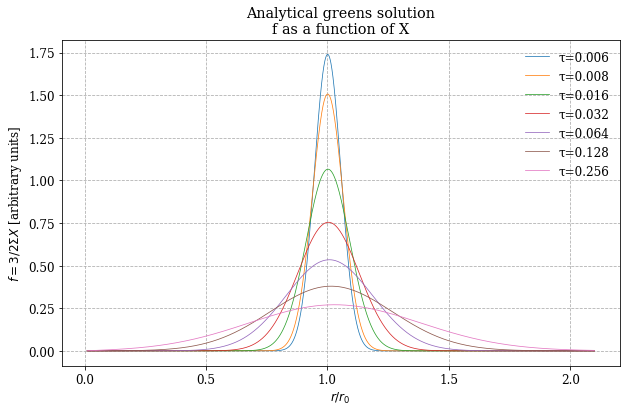

In [17]:
fig, axs = plt.subplots(figsize=(10,6)) 
times = [0.006, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256]
plt.grid(ls='--')
for τ in times:
    axs.plot(x, analytic_green(x, τ) * x * 3/2, label=f'τ={τ}', lw=0.75)

axs.set(title='Analytical greens solution\nf as a function of X', ylabel='$f=3/2 \Sigma X$ [arbitrary units]', xlabel='$r/r_0$')
plt.legend(frameon=False)

### Imposing the boundary condition $\frac{\partial}{\partial r}(\Sigma r^{3/2})=0$

$$\frac{\partial}{\partial r}(\Sigma r^{3/2})=0$$
$$\Rightarrow\frac{\partial}{\partial r}(\Sigma)\cdot r^{3/2}\;+\;\frac{3}{2}\Sigma r^{1/2}=0$$
$$\Sigma r^{1/2}=-\frac{2}{3}\;r^{3/2}\;\frac{\partial}{\partial r}\Sigma$$


In [18]:
N = 2001
x_i = 0.01
x_f = 2.1
x = np.linspace(x_i, x_f, N)
Δx = x[1] - x[0]
Δt = 0.004

def disk_evolution(t, Σ):
    boundary = -2/3 * x**(3/2) * get_first_dev(Σ, Δx)

    inner = Σ * x**(1/2)
    inner[0] = boundary[0]
    inner[-1] = boundary[-1]

    inner_dev = get_first_dev(inner, Δx)
    
    outer_dev = get_first_dev(x**(1/2) * inner_dev, Δx)

    #outer_dev[0] = 0
    #outer_dev[-1] = 0

    return 3/x * outer_dev

In [19]:
anal_inital = analytic_green(x, 0.006)

In [20]:
sol = solve_ivp(disk_evolution, [times[1], times[-1]], y0 = anal_inital, t_eval = times[1:], method = 'LSODA')

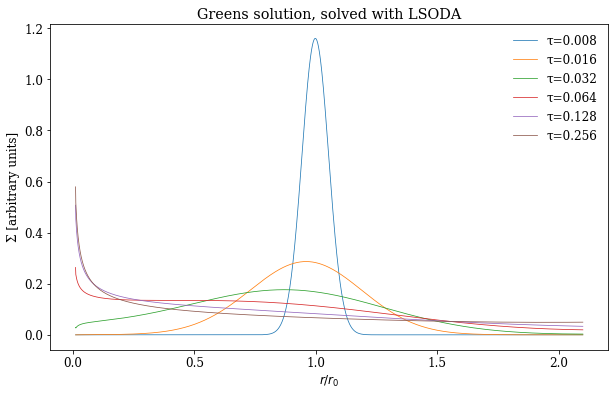

In [21]:
fig, axs = plt.subplots(figsize=(10,6)) 

for τ in times[1:]:
    axs.plot(x, sol.y[:, sol.t == τ], label=f'τ={τ}', lw=0.75)

axs.set(title='Greens solution, solved with LSODA', ylabel='Σ [arbitrary units]', xlabel='$r/r_0$')
plt.legend(frameon=False, loc = 'upper right')

### Imposeing $\frac{\partial f}{\partial r}=-\frac{f}{r}\quad\Rightarrow\quad\frac{\partial f}{\partial X}=-\frac{f}{X}$

In [22]:
@numba.njit
def time_diff(t, f):
    f_x1 = np.zeros(N)
    f_x2 = np.zeros(N)
   
   #Estimating 1. deriavative with Central finite difference scheme
    f_x1[1 : -1] = (-0.5 * f[:-2] + 0.5 * f[2:]) / Δx

    boundary = - f / x

    f_x1[0] = boundary[0]
    f_x1[-1] = boundary[-1]

    #Estimating 2. deriavative from 1. derivative
    f_x2[1 : -1] = (-0.5 * f_x1[:-2] + 0.5 * f_x1[2:]) / Δx

    f_x2[0] = (-3/2*f_x1[0] + 2 * f_x1[1] - 1/2 * f_x1[2]) / Δx

    f_x2[-1] = (1/2*f_x1[-3] - 2 * f_x1[-2] + 3/2 * f_x1[-1]) / Δx
    
    return x**(-2) * f_x2   

In [23]:
sol = solve_ivp(time_diff, [times[1], times[-1]], y0 = anal_inital * 3/2 * x, t_eval = times[1:], method = 'LSODA')

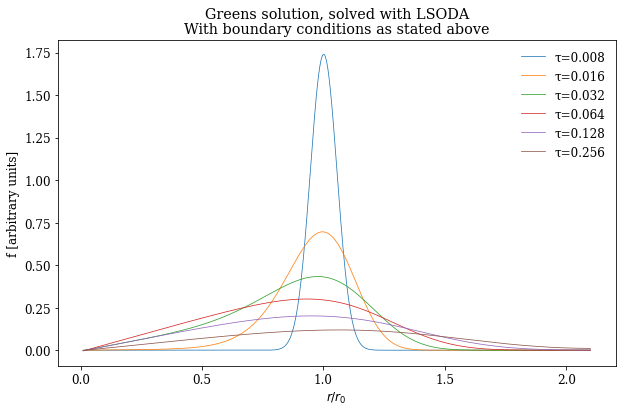

In [24]:
fig, axs = plt.subplots(figsize=(10,6)) 

for τ in times[1:]:
    axs.plot(x, sol.y[:, sol.t == τ], label=f'τ={τ}', lw=0.75)

axs.set(title='Greens solution, solved with LSODA\nWith boundary conditions as stated above', ylabel='f [arbitrary units]', xlabel='$r/r_0$')
plt.legend(frameon=False, loc = 'upper right')